In [109]:
import pandas as pd
import requests
import configparser
import sqlite3
import time
import requests

import numpy as np
import random

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
import pickle

from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

import lightgbm as lgb

import joblib


In [212]:

def init_kr_db():
    # 'kr_data.db'データベース作成
    conn = sqlite3.connect('kr_data.db')
    c = conn.cursor()

    # summoners テーブルを作成
    c.execute('''
    CREATE TABLE IF NOT EXISTS summoners (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        account_id TEXT,
        rank TEXT
    )
    ''')
    c.execute('''
    CREATE TABLE IF NOT EXISTS matches (
        match_id TEXT PRIMARY KEY AUTOINCREMENT,
        champion_id INTEGER,
        role TEXT,
        lane TEXT,
        summoner_id INTEGER,
        gameId TEXT,
        FOREIGN KEY(summoner_id) REFERENCES summoners(id)
    )
    ''')
    conn.commit()
    conn.close()

if __name__ == "__main__":
    init_kr_db()

In [76]:
# config.iniファイルの読み込み　api_keyの取得
config_ini = configparser.ConfigParser()
config_ini.read('config.ini', encoding='utf-8')
api_key ="RGAPI-98d9c730-0edd-411c-a3bd-cd9dbf9d9d90"
# サーバー選択
REGION = 'kr'

In [339]:
# APIデバック
def validate_api_key(api_key, REGION):
    url = f'https://{REGION}.api.riotgames.com/lol/summoner/v4/summoners/by-name/サンプルサモナー名?api_key={api_key}'
    response = requests.get(url)
    if response.status_code == 200:
        print("APIキーは有効です")
    else:
        print(f"APIキーの確認エラー: {response.status_code} - {response.json()}")

validate_api_key(api_key, REGION)


APIキーの確認エラー: 403 - {'status': {'message': 'Forbidden', 'status_code': 403}}


In [59]:

# チャレンジャーのデータを取得
def get_challenger_summoners():
    url ='https://kr.api.riotgames.com/lol/league-exp/v4/entries/RANKED_SOLO_5x5/CHALLENGER/I?page=1&api_key=RGAPI-9e3c1434-58c3-4774-bbfc-5e0dba747c8d'
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error: {response.status_code}")
        return None
a = get_challenger_summoners()



In [60]:
a

[{'leagueId': 'f00d084d-0795-3285-856e-43b2fbda61e4',
  'queueType': 'RANKED_SOLO_5x5',
  'tier': 'CHALLENGER',
  'rank': 'I',
  'summonerId': 'ERksfZOJcHW4p_JGdyUfDVbWLzCwjaW2dSGOhH6PTWnWQaY',
  'leaguePoints': 2069,
  'wins': 205,
  'losses': 119,
  'veteran': True,
  'inactive': False,
  'freshBlood': False,
  'hotStreak': True},
 {'leagueId': 'f00d084d-0795-3285-856e-43b2fbda61e4',
  'queueType': 'RANKED_SOLO_5x5',
  'tier': 'CHALLENGER',
  'rank': 'I',
  'summonerId': 'tbGHc1nJyQC0bi4IgYdPvvV5g16QJTnNAOJm-SP0POBI-uY',
  'leaguePoints': 1939,
  'wins': 326,
  'losses': 246,
  'veteran': True,
  'inactive': False,
  'freshBlood': False,
  'hotStreak': False},
 {'leagueId': 'f00d084d-0795-3285-856e-43b2fbda61e4',
  'queueType': 'RANKED_SOLO_5x5',
  'tier': 'CHALLENGER',
  'rank': 'I',
  'summonerId': '9w9tnnspnXeyrVjGjSNSBCKxn5WePRkQ89ZhRq9rlhHWKseesZt2nJisFg',
  'leaguePoints': 1927,
  'wins': 743,
  'losses': 660,
  'veteran': True,
  'inactive': False,
  'freshBlood': False,
  'ho

In [61]:
leagueIds = []
for item in a:
    leagueIds.append(item['leagueId'])
    
print(leagueIds)

['f00d084d-0795-3285-856e-43b2fbda61e4', 'f00d084d-0795-3285-856e-43b2fbda61e4', 'f00d084d-0795-3285-856e-43b2fbda61e4', 'f00d084d-0795-3285-856e-43b2fbda61e4', 'f00d084d-0795-3285-856e-43b2fbda61e4', 'f00d084d-0795-3285-856e-43b2fbda61e4', 'f00d084d-0795-3285-856e-43b2fbda61e4', 'f00d084d-0795-3285-856e-43b2fbda61e4', 'f00d084d-0795-3285-856e-43b2fbda61e4', 'f00d084d-0795-3285-856e-43b2fbda61e4', 'f00d084d-0795-3285-856e-43b2fbda61e4', 'f00d084d-0795-3285-856e-43b2fbda61e4', 'f00d084d-0795-3285-856e-43b2fbda61e4', 'f00d084d-0795-3285-856e-43b2fbda61e4', 'f00d084d-0795-3285-856e-43b2fbda61e4', 'f00d084d-0795-3285-856e-43b2fbda61e4', 'f00d084d-0795-3285-856e-43b2fbda61e4', 'f00d084d-0795-3285-856e-43b2fbda61e4', 'f00d084d-0795-3285-856e-43b2fbda61e4', 'f00d084d-0795-3285-856e-43b2fbda61e4', 'f00d084d-0795-3285-856e-43b2fbda61e4', 'f00d084d-0795-3285-856e-43b2fbda61e4', 'f00d084d-0795-3285-856e-43b2fbda61e4', 'f00d084d-0795-3285-856e-43b2fbda61e4', 'f00d084d-0795-3285-856e-43b2fbda61e4',

In [62]:
summonerIds = []
for item in a:
    summonerIds.append(item['summonerId'])
    
print(summonerIds)

['ERksfZOJcHW4p_JGdyUfDVbWLzCwjaW2dSGOhH6PTWnWQaY', 'tbGHc1nJyQC0bi4IgYdPvvV5g16QJTnNAOJm-SP0POBI-uY', '9w9tnnspnXeyrVjGjSNSBCKxn5WePRkQ89ZhRq9rlhHWKseesZt2nJisFg', 'N20ciBby_A0_RXjvdYLDjdsSCg4CSckObhsOTQI829X6cY-mdURDXHMrpg', 'VbKXN7W5cM2MVDCehqSSfKnaNd1qpuaeBGFiPLNrLUNAUcs', 'VQz_KSt8pDUrJPK2-j_s4-v1QTcm3drgNx9btJzd8QB-u_8', 'HdP0aTirnhL0UFZc3jA0Hz6CbocJHk3kt11-UFdqBRBumlki6yrAWNoWmg', 'QeWYcpJQPnDC8UKotd_8rmuTIxu4pX4w_bN-OY4hfseUYFw', '-cfInhG8UcvStyTgs3V-HO360DUvs4t9C3l4pZvc5vREDWct_ZwTbHGYNA', 'EEhI0-yryS8ryt6bBvALZRtr9T1DUnws3QbBu57y65JbCoo', 'zwWE8rsAyy9_w-8-gREWY8VQrW_sq1vakIRVgOUFhmqQ4BA', '4nHXYk7E0BQhZWrO-cmALPf-9IqGiTF_qw7u3f4eiCXOZlo', 'X_gYrlaoSA4_lEZyot0Hg3QrVJ9FYxNScqwIQuRJcxTUl20', 'Sxgiw2n65tZi9h5BE1ji4joxOVAH-x3hm2TUfqkKsE4O0LQzd1ZtpoEZVQ', '4q6-UKR00B6KEWqqZ8WXXprMtCETwMZdGqBPIgJ47gvXS1l9_q29X2Xz5Q', 'a-CYQijCKQ-LpvQYY-dnBk3KcOmiSxgOaoHVYEf_Tk_RD1s', 'sU4U3DT_ww_Jl6S77MwQPqwRMqenxsbZZgETcaOx2enI2NuZ51rswMp4nQ', 'A8-0AnK9CgjziVeRNn3gbI3Ol0pB4eJxzy153NreEQhsDQs', 'bV5

In [63]:
def get_account_ids(api_key, REGION):
    account_ids = []
    alldata= []
    puuid=[]
    url = f'https://{REGION}.api.riotgames.com/lol/summoner/v4/summoners/uCI6PYXCfnY5AXbARgWBxzSPBxso_-y80M4M0NYb3E__T8Y?api_key={api_key}'
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        account_ids.append(data['accountId'])
        puuid.append(data['puuid'])
        alldata.append(data)
        print(alldata)
    return account_ids

In [64]:
get_account_ids(api_key, REGION)

[]

In [65]:
def get_account_ids(api_key, REGION, summoner_ids):
    account_ids = []
    puuids = []
    all_data = []

    for i, summoner_id in enumerate(summoner_ids, start=1):
        url = f'https://{REGION}.api.riotgames.com/lol/summoner/v4/summoners/{summoner_id}?api_key={api_key}'
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json()
            account_ids.append(data['accountId'])
            puuids.append(data['puuid'])
            all_data.append(data)
            print(f"Summoner ID: {summoner_id} -> Account ID: {data['accountId']}, PUUID: {data['puuid']}")
        else:
            print(f"Error: {response.status_code} for Summoner ID: {summoner_id}")
            print(response.json())

        # リクエストの制限を考慮して待機
        if i % 100 == 0:
            time.sleep(70)
        elif i % 20 == 0:
            time.sleep(10)

    return account_ids, puuids, all_data


In [66]:
account_ids, puuids, all_data = get_account_ids(api_key, REGION, summonerIds)

print("Account IDs:", account_ids)
print("PUUIDs:", puuids)
print("All Data:", all_data)

Error: 403 for Summoner ID: ERksfZOJcHW4p_JGdyUfDVbWLzCwjaW2dSGOhH6PTWnWQaY
{'status': {'message': 'Forbidden', 'status_code': 403}}
Error: 403 for Summoner ID: tbGHc1nJyQC0bi4IgYdPvvV5g16QJTnNAOJm-SP0POBI-uY
{'status': {'message': 'Forbidden', 'status_code': 403}}
Error: 403 for Summoner ID: 9w9tnnspnXeyrVjGjSNSBCKxn5WePRkQ89ZhRq9rlhHWKseesZt2nJisFg
{'status': {'message': 'Forbidden', 'status_code': 403}}
Error: 403 for Summoner ID: N20ciBby_A0_RXjvdYLDjdsSCg4CSckObhsOTQI829X6cY-mdURDXHMrpg
{'status': {'message': 'Forbidden', 'status_code': 403}}
Error: 403 for Summoner ID: VbKXN7W5cM2MVDCehqSSfKnaNd1qpuaeBGFiPLNrLUNAUcs
{'status': {'message': 'Forbidden', 'status_code': 403}}
Error: 403 for Summoner ID: VQz_KSt8pDUrJPK2-j_s4-v1QTcm3drgNx9btJzd8QB-u_8
{'status': {'message': 'Forbidden', 'status_code': 403}}
Error: 403 for Summoner ID: HdP0aTirnhL0UFZc3jA0Hz6CbocJHk3kt11-UFdqBRBumlki6yrAWNoWmg
{'status': {'message': 'Forbidden', 'status_code': 403}}
Error: 403 for Summoner ID: QeWYcpJQ

KeyboardInterrupt: 

In [67]:
puuids

['a2kClbqDFDitYQXyETo7t4gc6lNMKQjgPQddTKtxibq9wG7uubpAx8ewJyPb_2TpaOpM_Pu9J89jKQ',
 'k8nvUcpsZrDFu1xjQeRqETDrMlEtxwTRkuRm5hjve1e-uvCQ-WzgN58k9uzkVNfnN90mg5-6cvzIFw',
 '_Weff7bjR1vayhG1L3rWuugsfGN3SUgtSoc-Y1M5Oc536rcAA4L09N_5LLsO2qSvNLKoZLavUB9t0Q',
 'HPH5KwmyP2ltOHEz0Q9x8WQO7MqCLWRp3T68Sj0AbQiYGJQZ9KAdBQtecToF90Uu2w_legKooav4ww',
 '0PHlESkcGmu5ki9rUJgbZn9Bg08uUUWZ58L0UmT_gh6ae0bimTxWpSYKRMafsifG2TydKNHc5fPm9Q',
 'jlP3JA8vgHWpsIdGRWKf8-hQHHMs7WCRifItqlN5CikMq_WdUg7oW_WCwIlj0WDLIad4Q05yMNonvQ',
 'JbiXD4ROkMOk2duaqDlpgSUyro_2S89qZdVljGG0OjBg6dBwAARc0uAKp3vJ5fTI-j-XckGSxG-J-Q',
 'I992ZEFnZJvhx3B-cD-4d65fBMSoZAVO27-CWZ3tJQbOZRUJVs7IlDP0NsEsrGWe0ognW9sYl7Io0A',
 'iGJF7rxwRxFI2N_CyjKBpEoesGsJhhyMQ15XG-hvRqHSdPGon_GJ7nOfNY6U5RDy6N3bu2_lvDEBoQ',
 'PbTpwMS4eomo-xqTNqvPQgQgMlB7wa-JMIWGpT1tN3_0jABtPAVjM9yhm-XMilgtm-c0IkG7K3o_pg',
 '3JqLPr9apAr0XAkgi_PZKaqSYG7cb9I3Jb9W0dZeq9Izrs7tU4bqKhFqMtJmociSZq3rPWCpPiYmfA',
 'pugMgd1aKR3lyckzM6BedKtUTWJ-wQtL20ouAolYpvXGT2dA9FqEg3KmX8GAyPo74DbTphGqrbPsvw',
 'Fd

In [29]:
# accountId
account_ids

['6XKQkwsbQ-6D-CqlUYW_fj5KfrxrCEkPjm4sWLPd7wMIJLo',
 'Zvj934iO5xPHcgqKWOJJdZy-8oBpmfjmXN3wtiWzhFB-C4AdgTPNuYTB',
 'jPvWi1U-mAYygtgCTt5ypc3Z_LhBlHQxq964ujKU13CoyV8',
 'ltuCbd7Tz3GCNWinzljynH1uJNbXS_UX6zkfojbSyVYQB5dmEFtwQ3C-',
 'hO_RYNMFMKlmEsI3v6vRoWa5HM0mZ8Vr04EpPqL1QIBR10B-N2ZoGImq',
 '72CFznXejCP8SW35sMKlxIIvFonZzl9IEN60dPtYgtRAH9s',
 'FARQBHZ5_AFiPjky9EfXKoE2S-VJuHyYeuBLETpw1vXgWg7KNrQjKBYW',
 'ABnmeKbGUjn0MvOn-bfh4_PFCbh0ScDjt9foVi45Raackio',
 'bUEG5wdfQjpqPVXBlosenKRyJt9INmcr-W_C72H9DzzdLxU',
 'B3vDKDreS_VvihBulnZKOBg7iJn4GnqHWz0ZQc9XrW9Novg5Y7JYtbVi',
 '5_a3kvzkuGsL6VXeKw2A2gHl3BMh4WLV1vsri7zOxdJA5O0',
 'kzBPZ6dC8u5QMUMy1BfddNoNjMgRk4cB4J5zRDuH-_tDAXhhFml9-Qqk',
 'O2Euph9byxhyd_LZwc-mez2Yxr-aWcv1Ksrft97DsBE79E6xEvsSxVls',
 'dVIPaDpvIEaLlStISZMeCg1XhvYZX2HKolOtx5yQUT3BdSG75FGHXulG',
 'eGjhK-XvdBkQbPT4ltpu-Cv28o7U7ziftHglgdHPha5sFlQ',
 'Gy3pucNb8xEKQa6cMwWgvltzDEYbNnC1iAmLctEgz_uWUEQ',
 'l46sMRlUSlAIGE2wIDuhkBiYpxgYUSarKbFeSMbhkikUcfeqEtn0INB6',
 'HXf8vsL6wZ2YIjH8OxLNgvI_yCk1YydEc

In [295]:
# チャレンジャーデータとpuuidをsqliteに
def info_account_id(account_ids, puuids):
    # データベースに接続
    conn = sqlite3.connect('kr_data.db')
    c = conn.cursor()
    # データの挿入
    for account_id, puuid_id in zip(account_ids, puuids):
        c.execute('''
        INSERT OR REPLACE INTO summoners(account_id, rank, puuid)
        VALUES(?,?,?)
        ''', (account_id, 'CHALLENGER', puuid_id))

    # 変更を保存して接続を閉じる
    conn.commit()
    conn.close()

In [30]:
info_account_id(account_ids, puuids)

NameError: name 'info_account_id' is not defined

In [297]:
# summonersを確認する
import sqlite3

dbname = 'kr_data.db'
conn = sqlite3.connect(dbname)
cur = conn.cursor()

# terminalで実行したSQL文と同じようにexecute()に書く
cur.execute('SELECT * FROM summoners')

# 中身を全て取得するfetchall()を使って、printする。
print(cur.fetchall())

cur.close()
conn.close()


[(601, 'aTIcoeQR_OFtxwry17skZR4Xxx2CISFH1tsgVi0Me0rhVP4ikf11HQ97', 'CHALLENGER', 'osVbkz4K1dXIj3DcQOH42RWgJ6kmC5AearRm7BUZzsPHPL5OgdXydo9avzmC5-eha8LbDj44sztm6Q'), (602, 's71y1LGQwSbXpV5g7XoVmGH7aY0Nr1egOLvN335NNljFwMJ7CsSPjfzB', 'CHALLENGER', 't6cbzT1151qpzEHRUQYxb6GXj8amTMQlM8RzVq5cBFsg9EHnbs0NjQP_sjm_IHYeZxwyO4ukaIFwWA'), (603, 'hsbH_2s6-346dmFeUq2yStmLq0cX29304Uda277QY4IBNfXOJ5N2V7bn', 'CHALLENGER', 'U2UDvgKAZz31eUtMrBeeVuqN3yqNl7MjXz9n30kWoMQ71VCgCpd-ft0Ak89RYu7J3ClTz-OFNcS-Rw'), (604, '85KY-vky3dLOcLY0QPw1vwQllLS9SZKwgfzma_ySMvvijqXXlK4Kmrj6', 'CHALLENGER', 'JxMIZzkYaTQW_uu8cMJUrKT1He_o7FUxVGcSL_mBYYdRdGdxv_ldzZ0_wiQSFFzP8br-Sn5-Bp30Ow'), (605, 'dIfAkxci5KFT5N6VFK_-iALIP8bLzp_smF1tbfQuBtoOiPDeWMJNvnMv', 'CHALLENGER', 'FnJWglsE3MfDHQ1kwJiYQnEPyBIOllH5ROCBw2vONgONX50BEInfPS2gg-j178cxg09iA39KLwqsyQ'), (606, 'GaxclkhG0nL6Q99AT3NzdBpghbW0_RHSVm6OEjW9M7U0', 'CHALLENGER', 'W8rLIOQ_9Da7eBss6kE16A_8kxQ_dNMNEa_3-eoTzf4L4MY5Wdug68QhItFeINXkYGRNewtn13FxFg'), (607, 'IF0PIqmhNItGeHaNJolo6D9JE2

In [274]:
conn = sqlite3.connect('kr_data.db')
# カーソルを作成
cursor = conn.cursor()
# テーブルの存在を確認するSQLクエリ
table_name = 'summoners'
check_table_query = f"SELECT name FROM sqlite_master WHERE type='table' AND name='{table_name}'"
# SQLクエリを実行
cursor.execute(check_table_query)
# 結果を取得
result = cursor.fetchone()
# テーブルの存在を確認
if result:
    print(f"{table_name} テーブルは存在します。")
else:
    print(f"{table_name} テーブルは存在しません。")
# 接続を閉じる
conn.close()

summoners テーブルは存在します。


In [291]:
# テーブルの列を確認

def get_table_columns(table_name):
    conn = sqlite3.connect('kr_data.db')
    c = conn.cursor()
    
    # PRAGMA table_infoを使用してテーブルの列情報を取得
    c.execute(f'PRAGMA table_info({table_name})')
    columns_info = c.fetchall()
    
    # 列名のリストを作成
    columns = [column[1] for column in columns_info]
    
    conn.close()
    return columns

def main():
    table_name = 'summoners'
    
    # テーブルの列名を取得
    columns = get_table_columns(table_name)
    print(f"Columns in table '{table_name}':")
    for column in columns:
        print(column)

if __name__ == "__main__":
    main()

Columns in table 'summoners':
id
account_id
rank
puuid


In [190]:
def fetch_column_data(db_name, table_name, column_name):
    conn = sqlite3.connect(db_name)
    c = conn.cursor()
    
    # 指定した列の情報を取得
    c.execute(f'SELECT {column_name} FROM {table_name}')
    rows = c.fetchall()
    
    conn.close()
    return rows

def main():
    db_name = 'kr_data.db'
    table_name = 'summoners'
    column_name = 'account_id'  # 取得したい列名を指定

    column_data = fetch_column_data(db_name, table_name, column_name)
    for row in column_data:
        print(row)

if __name__ == "__main__":
    main()


('8Je-G_XQkyw_LyOYPiTnjnQIHPHBxouXovYdscwA06jzSFcwUFaIHSIr',)
('pUMgsXZBqt0oqWpVofrG6N15lUEQXcOe583vME56GpzQojcDtTHmzFui',)
('1QhMX0RQaB2ihvHDs2mO2wobwE7osZlqSKgBX2QGeO6UJSeYaGwjcr8m',)
('SXI3Dr0cv3gkZXESOns67f6rkAL4IBgMwNQUpW8dzN_RCzHd03RqiwQM',)
('f2mcNZfP2ruTDvOtMgh6RJOlnoa0MxioIP67Vibdg-6hmriPw7qT0DgY',)
('O--VHbbkuF9oe3wKIqZ3ySfcm5KI7SX19UQKrevAgb5rorBiaY3lpXHv',)
('zNaYE7wR1ruefD7TEpGV6qmzWn8NKu9rux7VDI-McjhU0TfuzUMjpadF',)
('29-CX43NX8NZEll-Cenj8xm7WzqW2fDvQ-0wDnvBggkjgh4',)
('9WPKO5UyeFJyiFwbwN6WrDTwjjfXbm19ZgRaH5ELKEI813E',)
('h0W10be7_43ppoXEEUnpm-of2LzdgZBtIRv1Wx9i5wLR16g',)
('hsbH_2s6-346dmFeUq2yStmLq0cX29304Uda277QY4IBNfXOJ5N2V7bn',)
('tbw6SVTF1JwqY65ECGGNJ6HsKhGje6n8bFfkUVp1yPxJ1CM',)
('m9y0KHBJhc14GmYKzzG67IHuwhWDP6qsxh4pnllvAZcQ2UCTDMTle5Dz',)
('orQwfqLlFgQwsq1oBR9pyjsXjSQvZQxIJaVbE1Kk0dFwK_UWfl8TO6yE',)
('PuHLvKk8cKijllENq15Xhl82420Nwi2CxSIuc8hNdtqxH82zyZbp1Mge',)
('fvYhwP3czXeqkXlQHQf-0YJlkBeDSG4hbl_1kGhVWeme0je_8XJuDh2f',)
('vORnadS3sfZnMN4knqTchL9VhqpKMxlWMuIEtR6G5Y

In [203]:
def get_matchlist_by_account(api_key, REGION):
    url = f'https://{REGION}.api.riotgames.com/lol/match/v4/matchlists/by-account/SXI3Dr0cv3gkZXESOns67f6rkAL4IBgMwNQUpW8dzN_RCzHd03RqiwQM?api_key={api_key}'
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()['matches']
    else:
        print(f"Error: {response.status_code}")
        return None

# 関数を呼び出して結果を取得

d = get_matchlist_by_account(api_key, REGION,)



Error: 403


In [204]:
d

In [68]:
def matchlist_puu(api_key, puuids):
    all_matchlists = []
    x = 1
    for puuid in puuids:
        # url = f'https://{region}.api.riotgames.com/lol/match/v5/matches/by-puuid/{puuid}/ids?start=0&count=50&api_key={api_key}'
        url = f'https://asia.api.riotgames.com/lol/match/v5/matches/by-puuid/{puuid}/ids?start=0&count=100&api_key={api_key}'
        response = requests.get(url)
        if response.status_code == 200:
            matchlist = response.json()
            all_matchlists.append(matchlist)
            print(f"PUUID: {puuid} -> Matchlist: {matchlist}")
        else:
            print(f"Error: {response.status_code} for PUUID: {puuid}")
            print(response.json())

        # リクエストの制限を考慮して待機
        if x % 100 == 0:
            time.sleep(70)
        elif x % 20 == 0:
            time.sleep(10)
        x = x + 1
    
    return all_matchlists

In [71]:
region = 'asia'
matchlists = matchlist_puu(api_key, puuids)
for matchlist in matchlists:
    print(matchlist)

PUUID: a2kClbqDFDitYQXyETo7t4gc6lNMKQjgPQddTKtxibq9wG7uubpAx8ewJyPb_2TpaOpM_Pu9J89jKQ -> Matchlist: ['KR_7288103169', 'KR_7288067729', 'KR_7287440735', 'KR_7287349796', 'KR_7287289899', 'KR_7266593601', 'KR_7266480818', 'KR_7264621136', 'KR_7264536762', 'KR_7264439407', 'KR_7264333499', 'KR_7264245074', 'KR_7262815842', 'KR_7262769768', 'KR_7262723028', 'KR_7262682831', 'KR_7255935276', 'KR_7255918044', 'KR_7255877901', 'KR_7255851356', 'KR_7255821248', 'KR_7255766648', 'KR_7255707689', 'KR_7255639391', 'KR_7255561931', 'KR_7255364131', 'KR_7255292063', 'KR_7255183498', 'KR_7254946615', 'KR_7254471646', 'KR_7254419336', 'KR_7254358386', 'KR_7254314320', 'KR_7254251178', 'KR_7254189937', 'KR_7254147032', 'KR_7253537504', 'KR_7253495062', 'KR_7253185121', 'KR_7250786065', 'KR_7250515835', 'KR_7248784623', 'KR_7248751083', 'KR_7248701803', 'KR_7248654509', 'KR_7248590489', 'KR_7248523700', 'KR_7248435664', 'KR_7245019638', 'KR_7244996098', 'KR_7244934205', 'KR_7243730337', 'KR_7243709383'

In [72]:
matchlists

[['KR_7288103169',
  'KR_7288067729',
  'KR_7287440735',
  'KR_7287349796',
  'KR_7287289899',
  'KR_7266593601',
  'KR_7266480818',
  'KR_7264621136',
  'KR_7264536762',
  'KR_7264439407',
  'KR_7264333499',
  'KR_7264245074',
  'KR_7262815842',
  'KR_7262769768',
  'KR_7262723028',
  'KR_7262682831',
  'KR_7255935276',
  'KR_7255918044',
  'KR_7255877901',
  'KR_7255851356',
  'KR_7255821248',
  'KR_7255766648',
  'KR_7255707689',
  'KR_7255639391',
  'KR_7255561931',
  'KR_7255364131',
  'KR_7255292063',
  'KR_7255183498',
  'KR_7254946615',
  'KR_7254471646',
  'KR_7254419336',
  'KR_7254358386',
  'KR_7254314320',
  'KR_7254251178',
  'KR_7254189937',
  'KR_7254147032',
  'KR_7253537504',
  'KR_7253495062',
  'KR_7253185121',
  'KR_7250786065',
  'KR_7250515835',
  'KR_7248784623',
  'KR_7248751083',
  'KR_7248701803',
  'KR_7248654509',
  'KR_7248590489',
  'KR_7248523700',
  'KR_7248435664',
  'KR_7245019638',
  'KR_7244996098',
  'KR_7244934205',
  'KR_7243730337',
  'KR_724370

In [51]:
def test_matchlist_puu(api_key, puuids):
    all_matchlists = []
    x = 1
    for puuid in puuids:
        url = f'https://asia.api.riotgames.com/lol/match/v5/matches/by-puuid/{puuid}/ids?start=0&count=10&api_key={api_key}'
        response = requests.get(url)
        if response.status_code == 200:
            matchlist = response.json()  # 修正: 正しい変数名を使う
            all_matchlists.append(matchlist)  # 各PUUIDに対して別のリストを保存
            print(f"PUUID: {puuid} -> Matchlist: {matchlist}")
        else:
            print(f"Error: {response.status_code} for PUUID: {puuid}")
            print(response.json())

        # リクエストの制限を考慮して待機
        if x % 100 == 0:
            time.sleep(70)
        elif x % 20 == 0:
            time.sleep(10)
        x = x + 1
    
    return all_matchlists

In [52]:
region = 'asia'
test_matchlists = test_matchlist_puu(api_key, puuids)
for test_matchlist in matchlists:
    print(matchlist)

PUUID: a2kClbqDFDitYQXyETo7t4gc6lNMKQjgPQddTKtxibq9wG7uubpAx8ewJyPb_2TpaOpM_Pu9J89jKQ -> Matchlist: ['KR_7266593601', 'KR_7266480818', 'KR_7264621136', 'KR_7264536762', 'KR_7264439407', 'KR_7264333499', 'KR_7264245074', 'KR_7262815842', 'KR_7262769768', 'KR_7262723028']
PUUID: k8nvUcpsZrDFu1xjQeRqETDrMlEtxwTRkuRm5hjve1e-uvCQ-WzgN58k9uzkVNfnN90mg5-6cvzIFw -> Matchlist: ['KR_7273688035', 'KR_7273565140', 'KR_7273477506', 'KR_7273116843', 'KR_7273019612', 'KR_7270573168', 'KR_7270535472', 'KR_7270455848', 'KR_7270422817', 'KR_7270336844']
PUUID: _Weff7bjR1vayhG1L3rWuugsfGN3SUgtSoc-Y1M5Oc536rcAA4L09N_5LLsO2qSvNLKoZLavUB9t0Q -> Matchlist: ['KR_7266562403', 'KR_7264521505', 'KR_7264439407', 'KR_7263957433', 'KR_7263421541', 'KR_7262720625', 'KR_7262682831', 'KR_7262644947', 'KR_7262571857', 'KR_7260643929']
PUUID: HPH5KwmyP2ltOHEz0Q9x8WQO7MqCLWRp3T68Sj0AbQiYGJQZ9KAdBQtecToF90Uu2w_legKooav4ww -> Matchlist: ['KR_7283860506', 'KR_7283747892', 'KR_7283517523', 'KR_7283288064', 'KR_7283109388', '

In [54]:
test_matchlists

[['KR_7266593601',
  'KR_7266480818',
  'KR_7264621136',
  'KR_7264536762',
  'KR_7264439407',
  'KR_7264333499',
  'KR_7264245074',
  'KR_7262815842',
  'KR_7262769768',
  'KR_7262723028'],
 ['KR_7273688035',
  'KR_7273565140',
  'KR_7273477506',
  'KR_7273116843',
  'KR_7273019612',
  'KR_7270573168',
  'KR_7270535472',
  'KR_7270455848',
  'KR_7270422817',
  'KR_7270336844'],
 ['KR_7266562403',
  'KR_7264521505',
  'KR_7264439407',
  'KR_7263957433',
  'KR_7263421541',
  'KR_7262720625',
  'KR_7262682831',
  'KR_7262644947',
  'KR_7262571857',
  'KR_7260643929'],
 ['KR_7283860506',
  'KR_7283747892',
  'KR_7283517523',
  'KR_7283288064',
  'KR_7283109388',
  'KR_7282992904',
  'KR_7282750138',
  'KR_7282686747',
  'KR_7282643940',
  'KR_7281672527'],
 ['KR_7273688035',
  'KR_7273633266',
  'KR_7271938657',
  'KR_7271881385',
  'KR_7271809380',
  'KR_7271407224',
  'KR_7271352636',
  'KR_7271310456',
  'KR_7270959124',
  'KR_7270925301'],
 ['KR_7283053674',
  'KR_7282784863',
  'KR_7

In [366]:
def get_testmatch_data(region, test_matchlist, api_key):
    url = f'https://{region}.api.riotgames.com/lol/match/v5/matches/{test_matchlist}?api_key={api_key}'
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error: {response.status_code} for Match ID: {test_matchlist}")
        return None

def extract_match_info(match_data):
    if match_data is None:
        return None

    participant_info_list = []

    for participant in match_data['info']['participants']:
        participant_info = {
            'match_id': match_data['metadata']['matchId'],
            'game_duration': match_data['info']['gameDuration'],
            'championId': participant['championId'],
            'kills': participant['kills'],
            'deaths': participant['deaths'],
            'assists': participant['assists'],
            'total_damage_dealt': participant['totalDamageDealt'],
            'gold_earned': participant['goldEarned'],
            'vision_score': participant['visionScore'],
            'win': participant['win'],
            'lane': participant['individualPosition'],
            'team_id': participant['teamId']
        }
        participant_info_list.append(participant_info)

    return participant_info_list

all_participant_info = []
x = 0
for match_id in test_matchlist:
    x = x + 1
    match_data = get_testmatch_data(region, match_id, api_key)
    if match_data:
        participant_info_list = extract_match_info(match_data)
        all_participant_info.extend(participant_info_list)
        if x % 70 == 0:
            time.sleep(70)
        elif x % 20 == 0:
            time.sleep(10)


# プレイヤーデータフレーム
df_participants = pd.DataFrame(all_participant_info)

# マッチIDごとにグループ化して表示
grouped = df_participants.groupby('match_id')

for match_id, group in grouped:
    print(f"Match ID: {match_id}")
    print(group)

Match ID: KR_7098152566
          match_id  game_duration  championId  kills  deaths  assists  \
990  KR_7098152566            914          24      1       3        2   
991  KR_7098152566            914          76     13       1        7   
992  KR_7098152566            914         166      8       1        6   
993  KR_7098152566            914         145      2       1       10   
994  KR_7098152566            914         111      5       1       15   
995  KR_7098152566            914          23      3       3        0   
996  KR_7098152566            914         876      2       6        1   
997  KR_7098152566            914          18      1       6        1   
998  KR_7098152566            914          22      0       7        3   
999  KR_7098152566            914          16      1       7        3   

     total_damage_dealt  gold_earned  vision_score    win     lane  team_id  
990               51780         4956             6   True      TOP      100  
991             

In [368]:
df_participants


match_id  game_duration  championId  kills  deaths  assists  \
0    KR_7107364029           1102          69      4       2        1   
1    KR_7107364029           1102         421      0       4        5   
2    KR_7107364029           1102         517      3       2        2   
3    KR_7107364029           1102          81      5       5        1   
4    KR_7107364029           1102          99      2       8        6   
..             ...            ...         ...    ...     ...      ...   
995  KR_7098152566            914          23      3       3        0   
996  KR_7098152566            914         876      2       6        1   
997  KR_7098152566            914          18      1       6        1   
998  KR_7098152566            914          22      0       7        3   
999  KR_7098152566            914          16      1       7        3   

     total_damage_dealt  gold_earned  vision_score    win     lane  team_id  
0                100977         7685            16  False      TOP      100  
1                120697         5937            12  False   JUNGLE      100  
2                 56999         6296            13  False   MIDDLE      100  
3                 67319         7172            15  False   BOTTOM      100  
4                 21423         5561            46  False  UTILITY      100  
..                  ...          ...           ...    ...      ...      ...  
995               83326         6976             7  False      TOP      200  
996              101210         5600            10  False   JUNGLE      200  
997               49233         4899            12  False   MIDDLE      200  
998               37482         4397            11  False   BOTTOM      200  
999                7809         3816            22  False  UTILITY      200  

[1000 rows x 12 columns]

In [377]:
df = df_participants

In [43]:
# テスト用の試合取得
def get_sample_testmatch_data(region, api_key):
    url = f'https://{region}.api.riotgames.com/lol/match/v5/matches/KR_7281283363?api_key={api_key}'
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error: {response.status_code} for Match ID:")
        return None

def extract_match_info(match_data):
    if match_data is None:
        return None

    sample_participant_info_list = []

    for participant in match_data['info']['participants']:
        participant_info = {
            'game_duration': match_data['info']['gameDuration'],
            'championId': participant['championId'],
            'kills': participant['kills'],
            'deaths': participant['deaths'],
            'assists': participant['assists'],
            'total_damage_dealt': participant['totalDamageDealt'],
            'gold_earned': participant['goldEarned'],
            'vision_score': participant['visionScore'],
            'win': participant['win'],
            'lane': participant['individualPosition'],
            'team_id': participant['teamId']
        }
        sample_participant_info_list.append(participant_info)

    return participant_info_list




# プレイヤーデータフレーム
df_sample_participants = pd.DataFrame(participant_info_list)

# マッチIDごとにグループ化して表示
grouped = df_sample_participants.groupby('match_id')

for match_id, group in grouped:
    print(f"Match ID: {match_id}")
    print(group)

NameError: name 'participant_info_list' is not defined

In [55]:
import requests
import pandas as pd

# テスト用の試合取得
def get_sample_testmatch_data(region, api_key):
    url = f'https://{region}.api.riotgames.com/lol/match/v5/matches/KR_7279842546?api_key={api_key}'
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error: {response.status_code} for Match ID:")
        return None

# 試合データの抽出
def extract_match_info(match_data):
    if match_data is None:
        return None

    sample_participant_info_list = []

    for participant in match_data['info']['participants']:
        participant_info = {
            'match_id': match_data['metadata']['matchId'],  # match_idを追加
            'game_duration': match_data['info']['gameDuration'],
            'championId': participant['championId'],
            'kills': participant['kills'],
            'deaths': participant['deaths'],
            'assists': participant['assists'],
            'total_damage_dealt': participant['totalDamageDealt'],
            'gold_earned': participant['goldEarned'],
            'vision_score': participant['visionScore'],
            'win': participant['win'],
            'lane': participant['individualPosition'],
            'team_id': participant['teamId']
            
        }
        sample_participant_info_list.append(participant_info)

    return sample_participant_info_list

# サンプルデータ取得
match_data = get_sample_testmatch_data(region, api_key)

# 試合情報の抽出
participant_info_list = extract_match_info(match_data)

# データフレームに変換
df_sample_participants = pd.DataFrame(participant_info_list)

# マッチIDごとにグループ化して表示
grouped = df_sample_participants.groupby('match_id')

for match_id, group in grouped:
    print(f"Match ID: {match_id}")
    print(group)


Match ID: KR_7279842546
        match_id  game_duration  championId  kills  deaths  assists  \
0  KR_7279842546           1895         897      8       3       11   
1  KR_7279842546           1895         234     13       6       17   
2  KR_7279842546           1895          55      9       5       13   
3  KR_7279842546           1895         145     11       2       19   
4  KR_7279842546           1895         111      2       9       17   
5  KR_7279842546           1895          14      1      13       10   
6  KR_7279842546           1895         121      7       9       14   
7  KR_7279842546           1895         127      2       6       15   
8  KR_7279842546           1895         895     10       8       12   
9  KR_7279842546           1895         235      5       7       18   

   total_damage_dealt  gold_earned  vision_score    win     lane  team_id  
0              186193        15247            24   True      TOP      100  
1              306711        16017        

In [56]:
df_sample_participants

match_id  game_duration  championId  kills  deaths  assists  \
0  KR_7279842546           1895         897      8       3       11   
1  KR_7279842546           1895         234     13       6       17   
2  KR_7279842546           1895          55      9       5       13   
3  KR_7279842546           1895         145     11       2       19   
4  KR_7279842546           1895         111      2       9       17   
5  KR_7279842546           1895          14      1      13       10   
6  KR_7279842546           1895         121      7       9       14   
7  KR_7279842546           1895         127      2       6       15   
8  KR_7279842546           1895         895     10       8       12   
9  KR_7279842546           1895         235      5       7       18   

   total_damage_dealt  gold_earned  vision_score    win     lane  team_id  
0              186193        15247            24   True      TOP      100  
1              306711        16017            30   True   JUNGLE      100  
2              163888        13162            38   True   MIDDLE      100  
3              261251        17140            38   True   BOTTOM      100  
4               15876         8301            89   True  UTILITY      100  
5              115856         9034            25  False      TOP      200  
6              230150        12261            72  False   JUNGLE      200  
7              154759        11172            18  False   MIDDLE      200  
8              204678        16412             6  False   BOTTOM      200  
9               49932        11193            94  False  UTILITY      200

In [468]:
# test用
# マッチの詳細なデータ取得並びにデータフレーム化

def get_match_data(region, match_id):
    url = f'https://{region}.api.riotgames.com/lol/match/v5/matches/{match_id}?api_key=RGAPI-53ae178e-6496-4ac9-80a0-d62680f9eb8a'
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error: {response.status_code} for Match ID: {match_id}")
        return None

def extract_match_info(match_data, match_id):
    if match_data is None:
        return None

    participant_info_list = []

    for participant in match_data['info']['participants']:
        participant_info = {
            'match_id': match_id,
            'game_duration': match_data['info']['gameDuration'],
            'champion_id': participant['championId'],
            'kills': participant['kills'],
            'deaths': participant['deaths'],
            'assists': participant['assists'],
            'total_damage_dealt': participant['totalDamageDealt'],
            'gold_earned': participant['goldEarned'],
            'vision_score': participant['visionScore'],
            'win': 1 if participant['win'] else 0,
            'team_id': participant['teamId']
        }
        participant_info_list.append(participant_info)

    return participant_info_list



all_participant_info = []
x = 0

for match_id in test_matchlist:
    match_data = get_match_data(region, match_id)
    x = x + 1
    if match_data:
        participant_info_list = extract_match_info(match_data, match_id)
        all_participant_info.extend(participant_info_list)
        if x % 70 == 0:
            time.sleep(70)
        elif x % 20 == 0:
            time.sleep(10)

# プレイヤーデータフレーム
df_participants = pd.DataFrame(all_participant_info)

# 結果の表示
print(df_participants.head())


        match_id  game_duration  champion_id  kills  deaths  assists  \
0  KR_7107364029           1102           69      4       2        1   
1  KR_7107364029           1102          421      0       4        5   
2  KR_7107364029           1102          517      3       2        2   
3  KR_7107364029           1102           81      5       5        1   
4  KR_7107364029           1102           99      2       8        6   

   total_damage_dealt  gold_earned  vision_score  win  team_id  
0              100977         7685            16    0      100  
1              120697         5937            12    0      100  
2               56999         6296            13    0      100  
3               67319         7172            15    0      100  
4               21423         5561            46    0      100  


In [469]:
df_participants

match_id  game_duration  champion_id  kills  deaths  assists  \
0    KR_7107364029           1102           69      4       2        1   
1    KR_7107364029           1102          421      0       4        5   
2    KR_7107364029           1102          517      3       2        2   
3    KR_7107364029           1102           81      5       5        1   
4    KR_7107364029           1102           99      2       8        6   
..             ...            ...          ...    ...     ...      ...   
995  KR_7098152566            914           23      3       3        0   
996  KR_7098152566            914          876      2       6        1   
997  KR_7098152566            914           18      1       6        1   
998  KR_7098152566            914           22      0       7        3   
999  KR_7098152566            914           16      1       7        3   

     total_damage_dealt  gold_earned  vision_score  win  team_id  
0                100977         7685            16    0      100  
1                120697         5937            12    0      100  
2                 56999         6296            13    0      100  
3                 67319         7172            15    0      100  
4                 21423         5561            46    0      100  
..                  ...          ...           ...  ...      ...  
995               83326         6976             7    0      200  
996              101210         5600            10    0      200  
997               49233         4899            12    0      200  
998               37482         4397            11    0      200  
999                7809         3816            22    0      200  

[1000 rows x 11 columns]

In [499]:
matchlists

[['KR_7115283387',
  'KR_7114471346',
  'KR_7113243497',
  'KR_7112390592',
  'KR_7112355495',
  'KR_7111789330',
  'KR_7111741440',
  'KR_7111669522',
  'KR_7111318612',
  'KR_7111214326',
  'KR_7111153581',
  'KR_7111030891',
  'KR_7108800100',
  'KR_7108739257',
  'KR_7108665217',
  'KR_7108596000',
  'KR_7108546457',
  'KR_7108416494',
  'KR_7108390199',
  'KR_7108347579',
  'KR_7108327019',
  'KR_7108156092',
  'KR_7107771768',
  'KR_7107743982',
  'KR_7107712243',
  'KR_7107424226',
  'KR_7107337600',
  'KR_7107311416',
  'KR_7107133585',
  'KR_7107097054',
  'KR_7107069254',
  'KR_7107024714',
  'KR_7107008748',
  'KR_7106837946',
  'KR_7106831230',
  'KR_7106776187',
  'KR_7106724460',
  'KR_7106676976',
  'KR_7106641508',
  'KR_7106514068',
  'KR_7105694569',
  'KR_7105627284',
  'KR_7104546557',
  'KR_7104491982',
  'KR_7104294832',
  'KR_7104236488',
  'KR_7104027743',
  'KR_7103942992',
  'KR_7103068431',
  'KR_7102849424',
  'KR_7102772647',
  'KR_7102711228',
  'KR_710264

In [79]:
# マッチの詳細なデータ取得並びにデータフレーム化
# これ使う


def get_match_data(region, match_id, api_key):
    url = f'https://{region}.api.riotgames.com/lol/match/v5/matches/{match_id}?api_key={api_key}'
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error: {response.status_code} for Match ID: {match_id}")
        return None

def extract_match_info(match_data, match_id):
    if match_data is None:
        return None

    participant_info_list = []

    for participant in match_data['info']['participants']:
        participant_info = {
            'match_id': match_id,
            'game_duration': match_data['info']['gameDuration'],
            'champion_id': participant['championId'],
            'kills': participant['kills'],
            'deaths': participant['deaths'],
            'assists': participant['assists'],
            'total_damage_dealt': participant['totalDamageDealt'],
            'gold_earned': participant['goldEarned'],
            'vision_score': participant['visionScore'],
            'win': 1 if participant['win'] else 0,
            'team_id': participant['teamId']
        }
        participant_info_list.append(participant_info)

    return participant_info_list

all_participant_info = []
x = 0

for match_id in matchlists:
    for match2_id in match_id:
        match_data = get_match_data(region, match2_id, api_key)
        if match_data:
            participant_info_list = extract_match_info(match_data, match2_id)
            all_participant_info.extend(participant_info_list)
            x += 1
            print(f"Processed matches: {x}")
            
            if x % 100 == 0:
                print("Sleeping for 100 seconds to avoid rate limit...")
                time.sleep(100)

print("Data collection complete")

# プレイヤーデータフレーム
df_main_participants = pd.DataFrame(all_participant_info)

# 結果の表示
print(df_main_participants.head())

Processed matches: 1
Processed matches: 2
Processed matches: 3
Processed matches: 4
Processed matches: 5
Processed matches: 6
Processed matches: 7
Processed matches: 8
Processed matches: 9
Processed matches: 10
Processed matches: 11
Processed matches: 12
Processed matches: 13
Processed matches: 14
Processed matches: 15
Processed matches: 16
Processed matches: 17
Processed matches: 18
Processed matches: 19
Processed matches: 20
Processed matches: 21
Processed matches: 22
Processed matches: 23
Processed matches: 24
Processed matches: 25
Processed matches: 26
Processed matches: 27
Processed matches: 28
Processed matches: 29
Processed matches: 30
Processed matches: 31
Processed matches: 32
Processed matches: 33
Processed matches: 34
Processed matches: 35
Processed matches: 36
Processed matches: 37
Processed matches: 38
Processed matches: 39
Processed matches: 40
Processed matches: 41
Processed matches: 42
Processed matches: 43
Processed matches: 44
Processed matches: 45
Processed matches: 

In [80]:
df_main_participants

match_id  game_duration  champion_id  kills  deaths  assists  \
0       KR_7288103169           1312           38      7      15       25   
1       KR_7288103169           1312          201      3       9       38   
2       KR_7288103169           1312          150     11      16       15   
3       KR_7288103169           1312          147      4      10       34   
4       KR_7288103169           1312          360     23      16       15   
...               ...            ...          ...    ...     ...      ...   
201231  KR_7195782342           1415           19      4       5        4   
201232  KR_7195782342           1415           11      5       2        5   
201233  KR_7195782342           1415          127      1       3        9   
201234  KR_7195782342           1415           21      3       3        3   
201235  KR_7195782342           1415          147      1       2        8   

        total_damage_dealt  gold_earned  vision_score  win  team_id  
0                    69760        13778             0    0      100  
1                    23415        13151             0    0      100  
2                    80745        14919             0    0      100  
3                    87567        13727             0    0      100  
4                   204066        20048             0    0      100  
...                    ...          ...           ...  ...      ...  
201231              114503         9881            14    1      200  
201232              183427        10148            22    1      200  
201233              123161        10362            22    1      200  
201234              112066         9736            18    1      200  
201235               34264         6669            60    1      200  

[201236 rows x 11 columns]

In [511]:
x

420

In [82]:
df_main_participants.to_csv('2024worldsdata.csv', index=False)

In [470]:
df_grouped = df_participants.groupby(['match_id', 'team_id']).agg({
    'champion_id': list,  # チャンピオンIDをリスト形式でまとめる
    'gold_earned': 'sum',  # 合計ゴールド
    'total_damage_dealt': 'sum',  # 合計ダメージ
    'vision_score': 'sum',  # 合計ヴィジョンスコア
    'kills': 'sum',  # 合計キル
    'deaths': 'sum',  # 合計デス
    'assists': 'sum'  # 合計アシスト
}).reset_index()

# カラム名の調整
df_grouped.columns = ['match_id', 'team_id', 'champion_ids', 'team_gold', 'team_damage', 'team_vision', 'team_kills', 'team_deaths', 'team_assists']

# チーム1とチーム2の統計情報を同じ行にまとめる
df_wide = df_grouped.pivot(index='match_id', columns='team_id', values=['champion_ids', 'team_gold', 'team_damage', 'team_vision', 'team_kills', 'team_deaths', 'team_assists'])

# カラム名のフラット化
df_wide.columns = [f'{stat}_{team}' for stat, team in df_wide.columns]
df_wide.reset_index(inplace=True)

print("\nProcessed DataFrame:")
print(df_wide.head())


Processed DataFrame:
        match_id          champion_ids_100         champion_ids_200  \
0  KR_7098152566   [24, 76, 166, 145, 111]    [23, 876, 18, 22, 16]   
1  KR_7098192332  [80, 104, 142, 429, 412]  [897, 76, 136, 22, 111]   
2  KR_7098229887    [72, 9, 126, 145, 518]   [54, 163, 18, 429, 60]   
3  KR_7098330694    [2, 203, 163, 523, 53]   [85, 104, 22, 18, 555]   
4  KR_7098380149   [75, 254, 84, 222, 117]   [85, 121, 23, 221, 99]   

  team_gold_100 team_gold_200 team_damage_100 team_damage_200 team_vision_100  \
0         36013         25688          347755          279060              76   
1         27406         34550          226298          310234              65   
2         41208         52555          438362          573835             139   
3         25719         37171          234452          314165              62   
4         60125         53107          830908          786090             195   

  team_vision_200 team_kills_100 team_kills_200 team_deaths_100 

In [83]:

# マッチIDごとにグループ化して処理
df_main_grouped = df_main_participants.groupby(['match_id', 'team_id']).agg({
    'champion_id': list,  # チャンピオンIDをリスト形式でまとめる
    'gold_earned': 'sum',  # 合計ゴールド
    'total_damage_dealt': 'sum',  # 合計ダメージ
    'vision_score': 'sum',  # 合計ヴィジョンスコア
    'kills': 'sum',  # 合計キル
    'deaths': 'sum',  # 合計デス
    'assists': 'sum',  # 合計アシスト
    'win': 'max'  # 勝利情報を保持
}).reset_index()

# カラム名の調整
df_main_grouped.columns = ['match_id', 'team_id', 'champion_ids', 'team_gold', 'team_damage', 'team_vision', 'team_kills', 'team_deaths', 'team_assists', 'win']

# チーム1とチーム2の統計情報を同じ行にまとめる
df_wide = df_main_grouped.pivot(index='match_id', columns='team_id', values=['champion_ids', 'team_gold', 'team_damage', 'team_vision', 'team_kills', 'team_deaths', 'team_assists'])

# カラム名のフラット化
df_wide.columns = [f'{stat}_{team}' for stat, team in df_wide.columns]
df_wide.reset_index(inplace=True)

# 勝利情報を保持（チーム100の勝利情報を基にする）
df_wide['win'] = df_main_grouped[df_main_grouped['team_id'] == 100].set_index('match_id')['win'].reindex(df_wide['match_id']).values

# チャンピオンIDのリストを個別のカラムに展開
max_champions = 5  # 1チームあたりの最大チャンピオン数

for team in [100, 200]:
    for i in range(max_champions):
        df_wide[f'champion_{team}_{i+1}'] = df_wide[f'champion_ids_{team}'].apply(lambda x: x[i] if i < len(x) else np.nan)

# 不要なカラムの削除
df_wide.drop(columns=[f'champion_ids_{team}' for team in [100, 200]], inplace=True)

print("\nProcessed DataFrame without Lists:")
print(df_wide.head())


TypeError: object of type 'float' has no len()

In [84]:
# マッチIDごとにグループ化して処理
df_main_grouped = df_main_participants.groupby(['match_id', 'team_id']).agg({
    'champion_id': list,  # チャンピオンIDをリスト形式でまとめる
    'gold_earned': 'sum',  # 合計ゴールド
    'total_damage_dealt': 'sum',  # 合計ダメージ
    'vision_score': 'sum',  # 合計ヴィジョンスコア
    'kills': 'sum',  # 合計キル
    'deaths': 'sum',  # 合計デス
    'assists': 'sum',  # 合計アシスト
    'win': 'max'  # 勝利情報を保持
}).reset_index()

# カラム名の調整
df_main_grouped.columns = ['match_id', 'team_id', 'champion_ids', 'team_gold', 'team_damage', 'team_vision', 'team_kills', 'team_deaths', 'team_assists', 'win']

# チーム1とチーム2の統計情報を同じ行にまとめる
df_wide = df_main_grouped.pivot(index='match_id', columns='team_id', values=['champion_ids', 'team_gold', 'team_damage', 'team_vision', 'team_kills', 'team_deaths', 'team_assists'])

# カラム名のフラット化
df_wide.columns = [f'{stat}_{team}' for stat, team in df_wide.columns]
df_wide.reset_index(inplace=True)

# 勝利情報を保持（チーム100の勝利情報を基にする）
df_wide['win'] = df_main_grouped[df_main_grouped['team_id'] == 100].set_index('match_id')['win'].reindex(df_wide['match_id']).values

# チャンピオンIDのリストを個別のカラムに展開
max_champions = 5  # 1チームあたりの最大チャンピオン数

for team in [100, 200]:
    for i in range(max_champions):
        df_wide[f'champion_{team}_{i+1}'] = df_wide[f'champion_ids_{team}'].apply(
            lambda x: x[i] if isinstance(x, (list, tuple)) and i < len(x) else np.nan
        )

# 不要なカラムの削除
df_wide.drop(columns=[f'champion_ids_{team}' for team in [100, 200]], inplace=True)

print("\nProcessed DataFrame without Lists:")
print(df_wide.head())



Processed DataFrame without Lists:
        match_id team_gold_100 team_gold_200 team_damage_100 team_damage_200  \
0  KR_7125330005         34498         48204          364199          517449   
1  KR_7125340785         69195         76081          982677         1149589   
2  KR_7125370152         46186         40675          566843          541209   
3  KR_7126126100         54010         61000          719543          836867   
4  KR_7126939518         55191         63636          684572          867010   

  team_vision_100 team_vision_200 team_kills_100 team_kills_200  \
0             144             146             16             27   
1             228             228             31             38   
2             164             145             19              9   
3             186             231             26             32   
4             174             190             23             36   

  team_deaths_100  ... champion_100_1 champion_100_2 champion_100_3  \
0        

In [85]:
df_wide.to_csv('worlds2024main.csv', index=False)

In [86]:
# 全ての特徴量を使って学習データを準備
X = df_wide.drop(columns=['match_id', 'win'])
y = df_wide['win']

# 訓練データとテストデータの分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [87]:
# モデルの学習
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# テストデータでの予測と精度の計算
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.9577


In [88]:
model_filename = '2024worlds_AI.pkl'
joblib.dump(clf, model_filename)

['2024worlds_AI.pkl']

In [114]:

# データの読み込み
file_path = '2024worldsoutput_file_cleaned.csv'
df = pd.read_csv(file_path)

# 保持するカラム
columns_to_keep = ['win', 'champion_100_1', 'champion_100_2', 'champion_100_3', 'champion_100_4', 'champion_100_5',
                   'champion_200_1', 'champion_200_2', 'champion_200_3', 'champion_200_4', 'champion_200_5']

# 特徴量とターゲット変数の設定
X = df[columns_to_keep[1:]]  # チャンピオン情報
y = df['win']  # ターゲット変数

# 訓練データとテストデータの分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# モデルの学習
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# テストデータでの予測と精度の計算
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')
joblib.dump(clf, '2024worlds_champion_only_AI.pkl')

Accuracy: 0.5412


['2024worlds_champion_only_AI.pkl']

In [90]:
# 精度テスト
file_path = 'worlds2024main.csv'
df = pd.read_csv(file_path)

# 保持するカラム
columns_to_keep = ['win', 'champion_100_1', 'champion_100_2', 'champion_100_3', 'champion_100_4', 'champion_100_5',
                   'champion_200_1', 'champion_200_2', 'champion_200_3', 'champion_200_4', 'champion_200_5']

# すべてのカラムを取得
all_columns = df.columns

# 保持するカラム以外のカラムをゼロに設定
for col in all_columns:
    if col not in columns_to_keep:
        df[col] = 0

# 結果のデータフレームを表示
print(df)

# 必要に応じて結果を新しいCSVファイルに保存
df.to_csv('2024worldsoutput_file.csv', index=False)

       match_id  team_gold_100  team_gold_200  team_damage_100  \
0             0              0              0                0   
1             0              0              0                0   
2             0              0              0                0   
3             0              0              0                0   
4             0              0              0                0   
...         ...            ...            ...              ...   
11343         0              0              0                0   
11344         0              0              0                0   
11345         0              0              0                0   
11346         0              0              0                0   
11347         0              0              0                0   

       team_damage_200  team_vision_100  team_vision_200  team_kills_100  \
0                    0                0                0               0   
1                    0                0                

In [101]:
df_test = pd.read_csv('2024worldsoutput_file_cleaned.csv')

# 特徴量（championデータ）とターゲット（win）の分離
X_test = df_test[['champion_100_1', 'champion_100_2', 'champion_100_3', 'champion_100_4', 'champion_100_5',
                  'champion_200_1', 'champion_200_2', 'champion_200_3', 'champion_200_4', 'champion_200_5']]
y_test = df_test['win']

# 学習時のカラムを取得
expected_columns = X_train.columns

# テストデータに学習時のカラムがない場合、0で埋める
for col in expected_columns:
    if col not in X_test.columns:
        X_test.loc[:, col] = 0


# カラムの順序を学習時と一致させる
X_test = X_test[expected_columns]

# 2. 学習済みモデルの読み込み
model_filename = '2024worlds_champion_only_AI.pkl'
clf = joblib.load(model_filename)

# 3. テストデータでの予測
y_pred = clf.predict(X_test)

# 4. 精度評価
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')


Accuracy: 0.9069


In [6]:
test_X = df.drop(columns=['match_id', 'win'])
test_y = df['win']

In [15]:
# テストデータでの予測と精度の計算
with open('lolperfect_AI.pkl', 'rb') as file:
    clf = pickle.load(file)

y_pred = clf.predict(test_X)
accuracy = accuracy_score(test_y, y_pred)
print(f'Accuracy: {accuracy:.4f}')

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x80 in position 0: invalid start byte

In [118]:
import pandas as pd

# CSVファイルの読み込み
df = pd.read_csv('worlds2024main.csv')

# 指定した列を削除
columns_to_drop = ['match_id']
df = df.drop(columns=columns_to_drop)

# NaNがある行を削除
df = df.dropna()

# 小数点以下の数字を削除（切り捨て）
df = df.applymap(lambda x: int(x) if isinstance(x, float) else x)

# 結果を新しいCSVファイルに保存
df.to_csv('worlds2024main.csv', index=False)



/var/folders/lh/kbqsmt_x66bczb5vvzl3gr900000gn/T/ipykernel_57367/4266998307.py:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: int(x) if isinstance(x, float) else x)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000354 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1666
[LightGBM] [Info] Number of data points in the train set: 8874, number of used features: 10
[LightGBM] [Info] Start training from score -0.807134
[LightGBM] [Info] Start training from score -0.590834
[1 1 1 ... 1 1 1]
Acc : 0.5412347904461469


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

findfont: Font family 'Meiryo' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
f

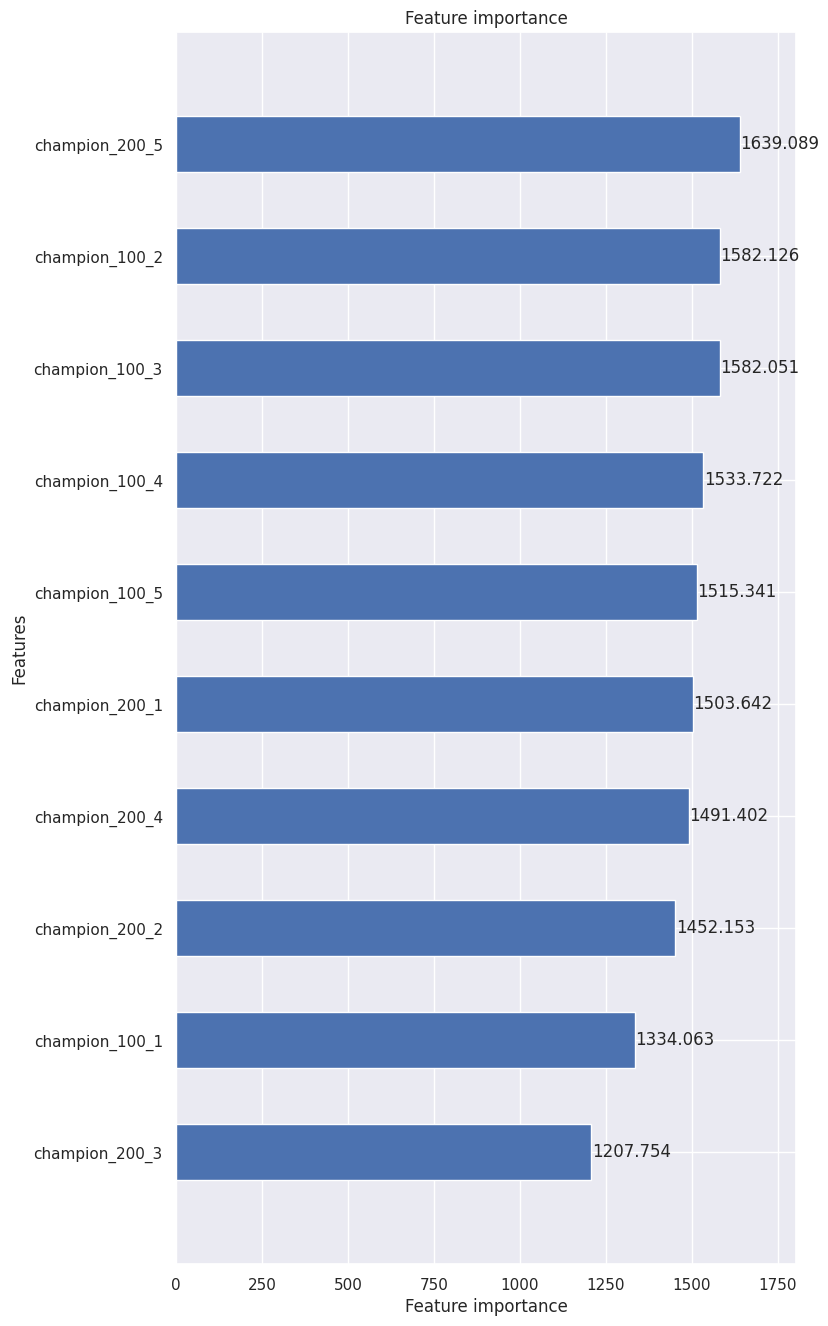

In [116]:
#データの読み込み
df = pd.read_csv('2024worldsoutput_file_cleaned.csv',encoding='shift-jis')

#予測ターゲットの格納（品種：E列）
target_df = df[["win"]]
#特徴量の格納（説明変数：A~D列）
train_df = df.iloc[:,1:11]

#モデル学習のための、訓練データとテストデータを7:3で分割
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_df, target_df, test_size=0.2, random_state=42)

#XGBoostで学習するためのデータ形式に変換
dtrain = lgb.Dataset(X_train, y_train)
dvalid = lgb.Dataset(X_test, y_test)

#モデルパラメータの設定
params = {'objective':'multiclass','num_class':2,'metric' : {'multi_error'}}
model = lgb.train(params,dtrain)

#予測の実行と書き出し
pred_prob = model.predict(X_test)
pred = np.argmax(pred_prob,axis = 1)
print(pred)


#モデル評価
acc = accuracy_score(y_test,pred)
print('Acc :', acc)

# 性能向上に寄与する度合いで重要度をプロット
lgb.plot_importance(model, height = 0.5, figsize = (8,16), importance_type='gain')


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000764 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1666
[LightGBM] [Info] Number of data points in the train set: 8874, number of used features: 10
[LightGBM] [Info] Start training from score -0.807134
[LightGBM] [Info] Start training from score -0.590834
[1 1 1 ... 1 1 1]
Acc : 0.5412347904461469


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

findfont: Font family 'Meiryo' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
f

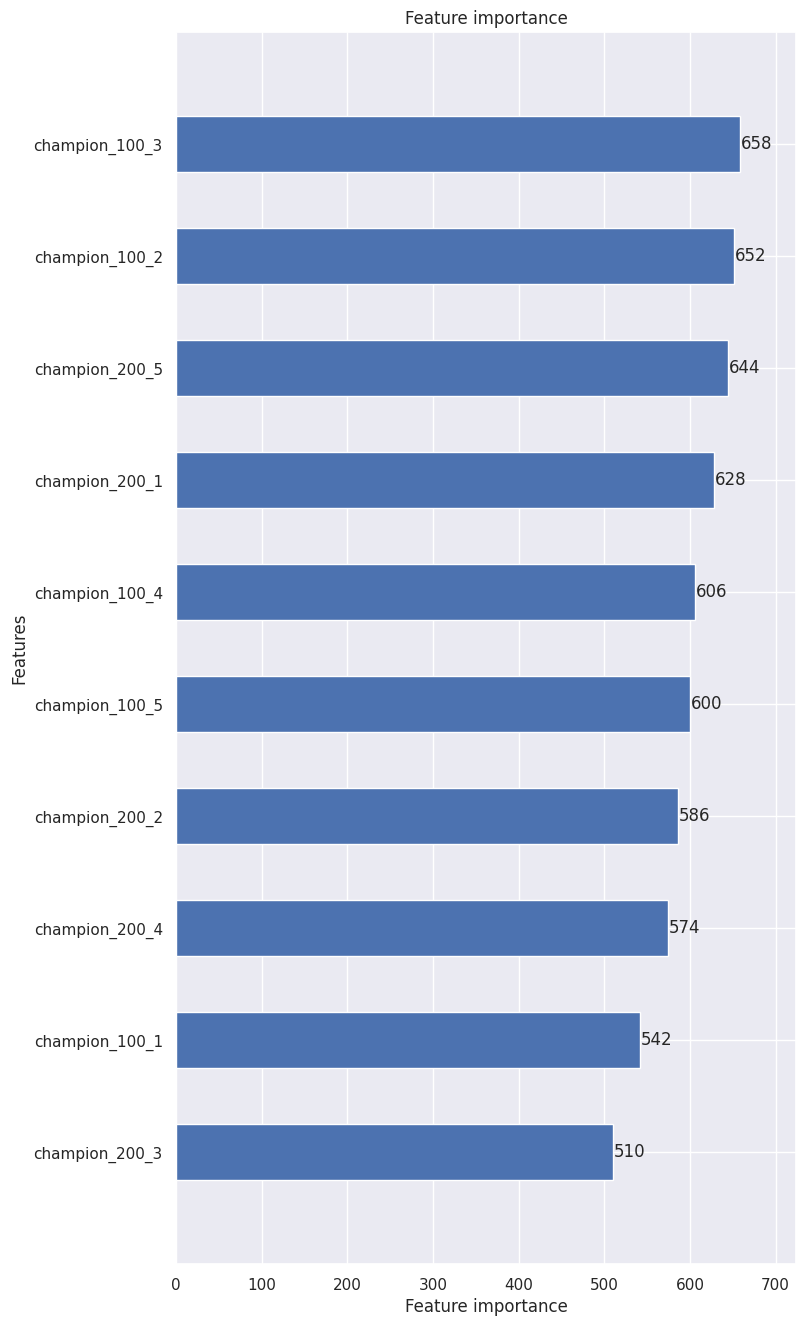

In [117]:
#データの読み込み
df = pd.read_csv('2024worldsoutput_file_cleaned.csv',encoding='shift-jis')

#予測ターゲットの格納（品種：E列）
target_df = df[["win"]]
#特徴量の格納（説明変数：A~D列）
train_df = df.iloc[:,1:11]

#モデル学習のための、訓練データとテストデータを7:3で分割
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_df, target_df, test_size=0.2, random_state=42)

#XGBoostで学習するためのデータ形式に変換
dtrain = lgb.Dataset(X_train, y_train)
dvalid = lgb.Dataset(X_test, y_test)

#モデルパラメータの設定
params = {'objective':'multiclass','num_class':2,'metric' : {'multi_error'}}
model = lgb.train(params,dtrain)

#予測の実行と書き出し
pred_prob = model.predict(X_test)
pred = np.argmax(pred_prob,axis = 1)
print(pred)


#モデル評価
acc = accuracy_score(y_test,pred)
print('Acc :', acc)

# 性能向上に寄与する度合いで重要度をプロット
lgb.plot_importance(model, height = 0.5, figsize = (8,16))


In [119]:
import pandas as pd

# CSVファイルを読み込み
file_path = 'worlds2024main.csv'  # ここにファイルのパスを指定
df = pd.read_csv(file_path)

# 'win' カラムを一番最後に移動
cols = [col for col in df.columns if col != 'win'] + ['win']
df = df[cols]

# 修正されたデータフレームを保存
output_file_path = 'now_worlds2024main.csv'  # 保存先のパスを指定
df.to_csv(output_file_path, index=False)

print(f"修正されたCSVファイルは {output_file_path} に保存されました。")


修正されたCSVファイルは now_worlds2024main.csv に保存されました。


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4433
[LightGBM] [Info] Number of data points in the train set: 8874, number of used features: 22
[LightGBM] [Info] Start training from score -0.807134
[LightGBM] [Info] Start training from score -0.590834
[0 0 0 ... 1 0 0]
Acc : 0.96800360522758


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

findfont: Font family 'Meiryo' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
f

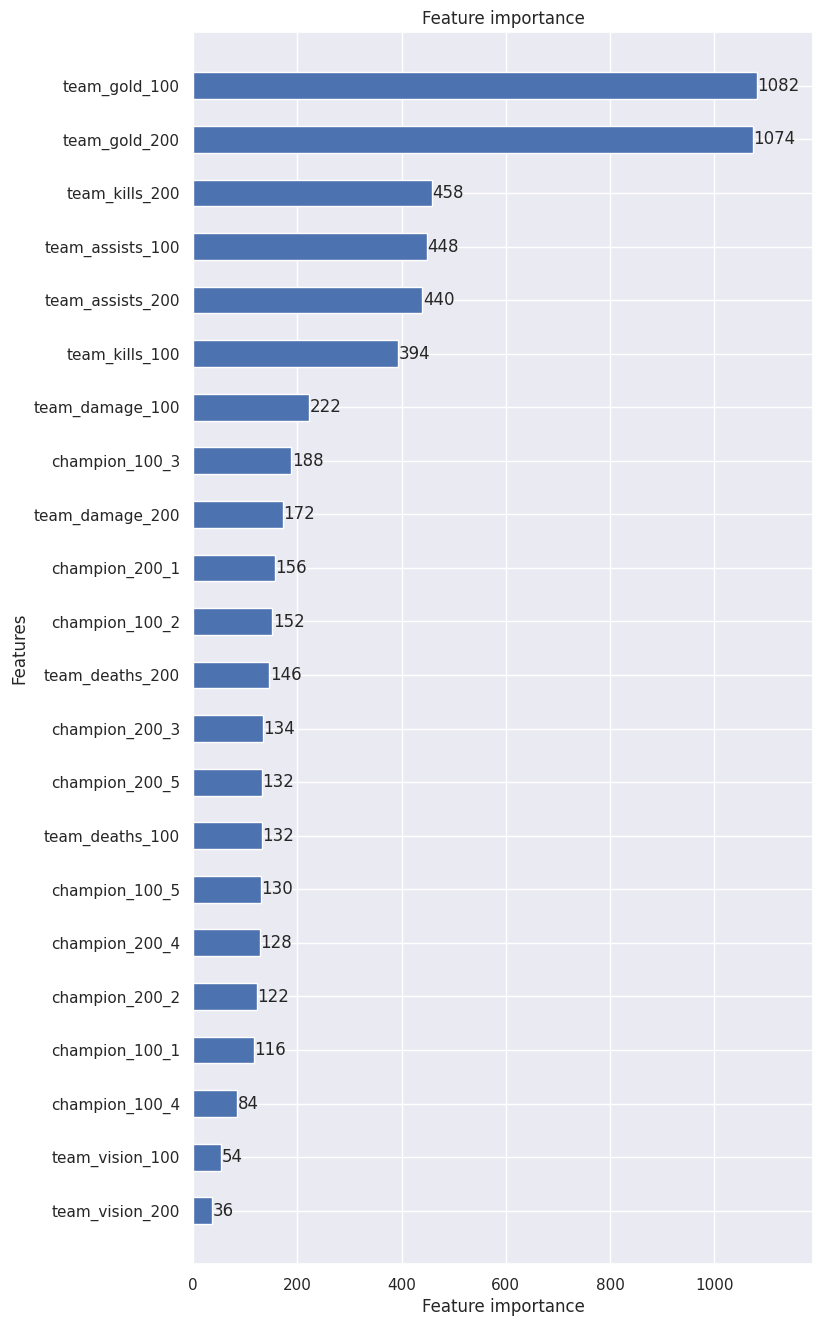

In [124]:
#データの読み込み
df = pd.read_csv('now_worlds2024main.csv',encoding='shift-jis')

#予測ターゲットの格納（品種：E列）
target_df = df[["win"]]
#特徴量の格納（説明変数：A~D列）
train_df = df.iloc[:,0:22]

#モデル学習のための、訓練データとテストデータを7:3で分割
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_df, target_df, test_size=0.2, random_state=42)

#XGBoostで学習するためのデータ形式に変換
dtrain = lgb.Dataset(X_train, y_train)
dvalid = lgb.Dataset(X_test, y_test)

#モデルパラメータの設定
params = {'objective':'multiclass','num_class':2,'metric' : {'multi_error'}}
model = lgb.train(params,dtrain)

#予測の実行と書き出し
pred_prob = model.predict(X_test)
pred = np.argmax(pred_prob,axis = 1)
print(pred)


#モデル評価
acc = accuracy_score(y_test,pred)
print('Acc :', acc)

# 性能向上に寄与する度合いで重要度をプロット
lgb.plot_importance(model, height = 0.5, figsize = (8,16))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4433
[LightGBM] [Info] Number of data points in the train set: 8874, number of used features: 22
[LightGBM] [Info] Start training from score -0.807134
[LightGBM] [Info] Start training from score -0.590834
[0 0 0 ... 1 0 0]
Acc : 0.96800360522758


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

findfont: Font family 'Meiryo' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
f

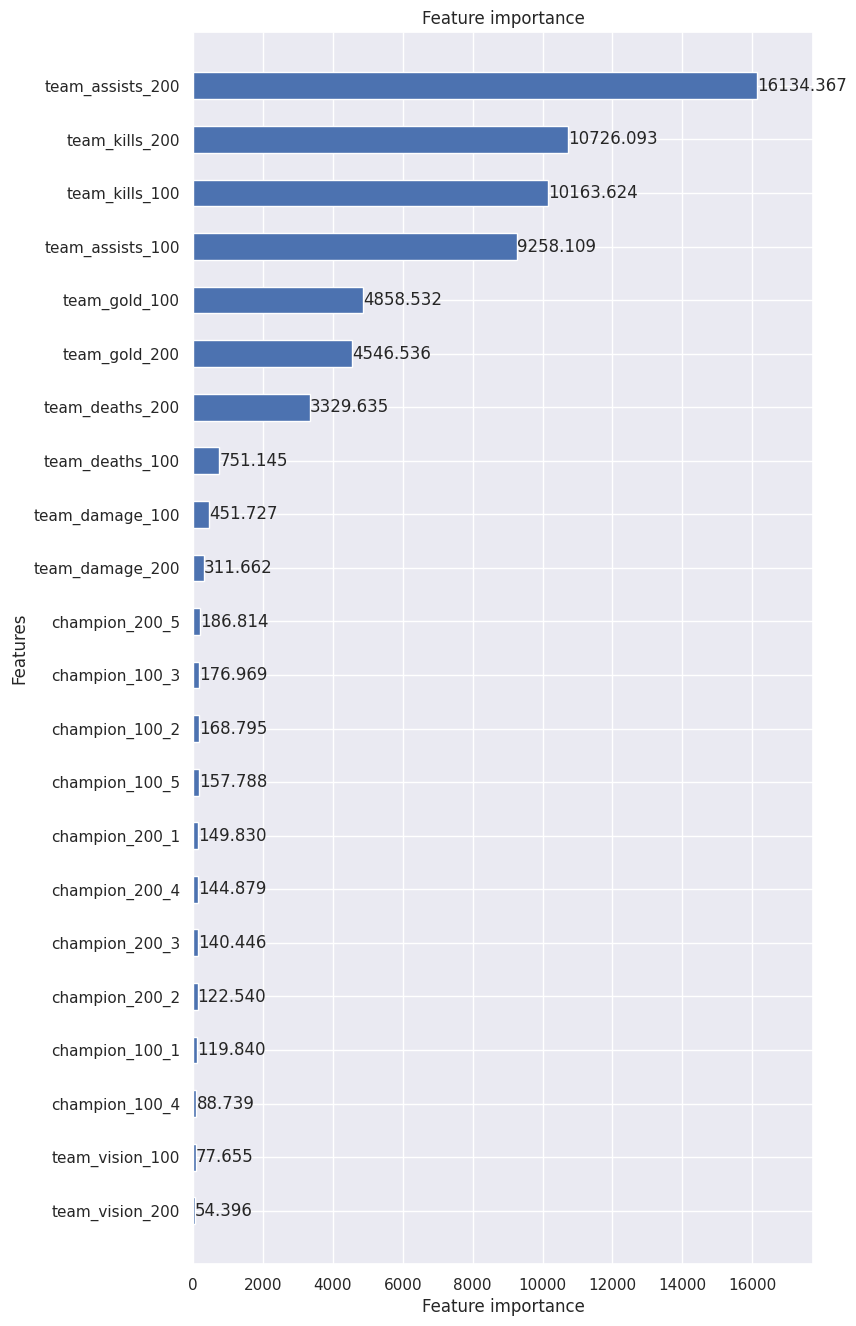

In [125]:
#データの読み込み
df = pd.read_csv('now_worlds2024main.csv',encoding='shift-jis')

#予測ターゲットの格納（品種：E列）
target_df = df[["win"]]
#特徴量の格納（説明変数：A~D列）
train_df = df.iloc[:,0:22]

#モデル学習のための、訓練データとテストデータを7:3で分割
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_df, target_df, test_size=0.2, random_state=42)

#XGBoostで学習するためのデータ形式に変換
dtrain = lgb.Dataset(X_train, y_train)
dvalid = lgb.Dataset(X_test, y_test)

#モデルパラメータの設定
params = {'objective':'multiclass','num_class':2,'metric' : {'multi_error'}}
model = lgb.train(params,dtrain)

#予測の実行と書き出し
pred_prob = model.predict(X_test)
pred = np.argmax(pred_prob,axis = 1)
print(pred)


#モデル評価
acc = accuracy_score(y_test,pred)
print('Acc :', acc)

# 性能向上に寄与する度合いで重要度をプロット
lgb.plot_importance(model, height = 0.5, figsize = (8,16), importance_type='gain')